In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Manual seed, do not change so this is reproducible.
### First 4 digits of pi for good luck lol

In [3]:
torch.manual_seed(3141)

# Load Data, do not touch

In [4]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [5]:
directions = m["direction_YQ1"].flatten() - 1
np.unique(directions)
directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [6]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [7]:
traj_origin.shape

(156, 3, 151)

In [8]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

# Do not touch, this was tedious af

In [9]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

all_inputs = torch.tensor(traj[:, :, 0], dtype=torch.float32)
all_targets = torch.tensor(traj[:, :, :], dtype=torch.float32)

# This arch works pretty well

In [10]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        out = self.linear(out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev

### This is necessary for gradient explosion which I'm using to re-train the network after pruning, do not change. It will become clear after the pruning how it's used

In [11]:
class AscentFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_input):
        return -grad_input


def make_ascent(loss):
    return AscentFunction.apply(loss)

# Training loop you can use to also test the pruned etc. models

In [12]:
def train(
    model: SimpleRNN,
    targets: torch.Tensor,
    optimizer: optim.Optimizer,
    lr0: int,
    loss_func: callable,
    n_epochs: int,
    gradient_ascent: bool = False
) -> SimpleRNN:
    """
    Parameters
    ----------

    SimpleRNN model instance

    `all_targets` created above

    optimizer, Adam seems to work well
    
    lr0, initial learning rate

    loss function, just MSE for now
    
    Returns
    -------
    
    SimpleRNN model instance, losses
    """

    losses = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()

    for n_epoch in tqdm(range(n_epochs)):
        # give position and target direction [x, y, z, direction] of only first index!
        x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4) # [n_trajs, 1, (x0, y0, z0, dir_0)]
        y = all_targets.swapaxes(1, 2)[:, :, :3]

        output, hidden_prev = model(x.cuda(), hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        if not gradient_ascent:
            loss = loss_func(output, y.cuda())
        else:
            loss = make_ascent(loss_func(output, y.cuda()))
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduces learnign rate every 250 epochs, this helps A LOT
        if n_epoch % 250 == 0:
            lr0 = lr0 / 10
            for g in optimizer.param_groups:
                g['lr'] = lr0

        losses.append(loss.detach().cpu().numpy().item())
    
    return model, losses

# Create the model

## these params seem to work well

In [13]:
simple_rnn = SimpleRNN(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

## Train

In [14]:
lr = 0.001

simple_rnn, ls = train(
    model=simple_rnn,
    targets=all_targets,
    optimizer=optim.Adam(simple_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=3000
)

  0%|                                                                                | 0/3000 [00:00<?, ?it/s]Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 763.20it/s]


# all losses and last 10 losses printed

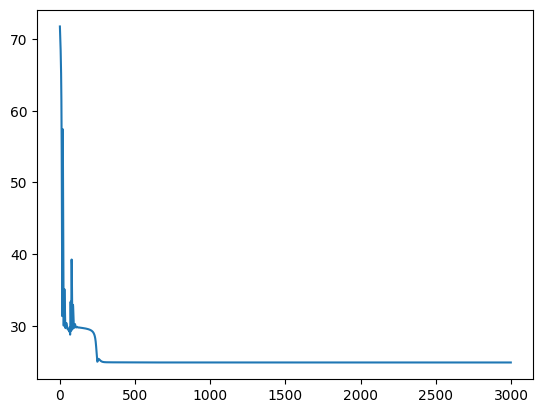

In [15]:
%matplotlib inline
plt.plot(ls)
plt.show()

### Last 10 losses, I get 24.8

In [16]:
ls[-10:]

[24.864377975463867,
 24.864389419555664,
 24.86440086364746,
 24.864398956298828,
 24.864383697509766,
 24.864389419555664,
 24.864383697509766,
 24.8643741607666,
 24.864370346069336,
 24.8643798828125]

# Just a function to plot predictions

In [17]:
def plot_preds(model, inputs):
    ax = plt.figure().add_subplot(projection='3d')

    for ix_plot in tqdm(range(156)): # 156 trajs
        preds = list()
        hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()
        for _ in range(150): # length of each traj is 150
            pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
            input_x = pred
            preds.append(pred[0, ix_plot, 0, :].detach().cpu().numpy())
        preds_3d = np.vstack(preds)

        ax.plot(preds_3d[:, 0], preds_3d[:, 1], preds_3d[:, 2])
    plt.show()

100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:04<00:00, 33.27it/s]


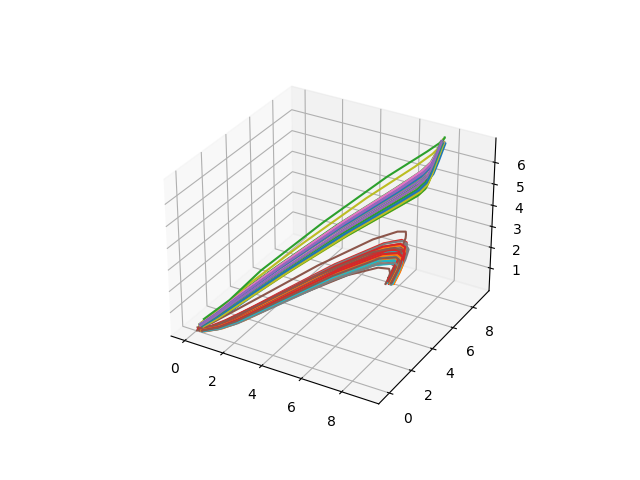

In [18]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
plot_preds(simple_rnn, inputs)

# Heatmap of weights

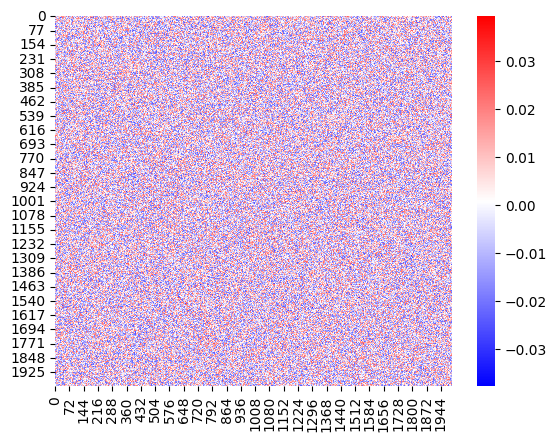

In [19]:
%matplotlib inline

sns.heatmap(simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

## Save the model first before pruning so we can have a copy

In [20]:
torch.save(simple_rnn.state_dict(), "./simple_rnn.pt")

In [21]:
prune_rnn = SimpleRNN(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

In [22]:
prune_rnn.load_state_dict(torch.load("./simple_rnn.pt"))

<All keys matched successfully>

# Sanity check 

In [23]:
(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy() == simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy()).all()

True

# Import pruning stuff

In [24]:
import torch.nn.utils.prune as prune

# This class is a pruner
## Set `n_prune` to number of neurons to prune

In [25]:
n_prune = 400

class Pruner(prune.BasePruningMethod):
    PRUNING_TYPE = 'unstructured'

    def compute_mask(self, t, default_mask):
        mask = default_mask.clone()
        print(mask.shape)
        mask[:n_prune, n_prune:] = 0
        mask[n_prune:, :n_prune] = 0
        return mask

    
def pruner(module, name):
    Pruner.apply(module, name)
    return module

# Apply the pruner

In [26]:
prune_rnn.rnn = pruner(prune_rnn.rnn, "weight_hh_l0")

torch.Size([2000, 2000])


Verifying the prunings

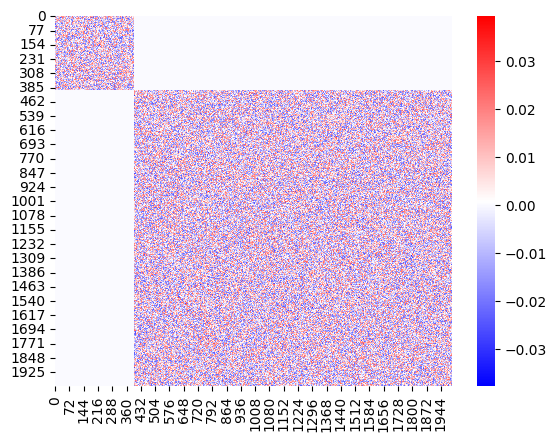

In [27]:
%matplotlib inline

sns.heatmap(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

# Predictions with pruned model!

  0%|                                                                                 | 0/156 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 22.00it/s]


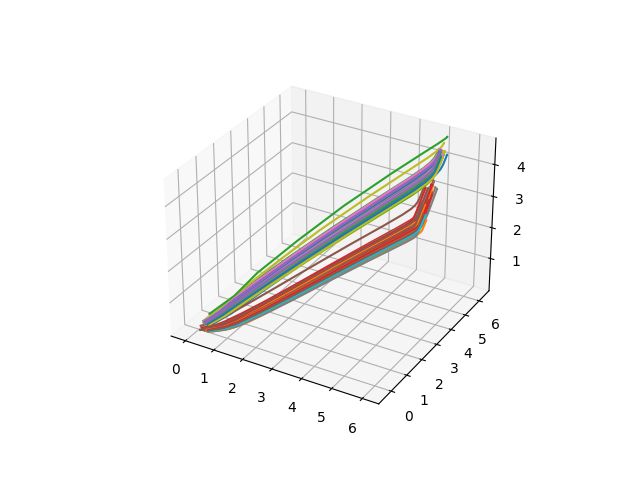

In [28]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
plot_preds(prune_rnn, inputs)

## As you can see the pruned model produces garbage in comparison, less directionality. 

# Before re-training, first use gradient explosion for a few epochs before re-training to get out of the minima that was optimized for the previous network structure

In [29]:
lr = 0.001

prune_rnn, ls = train(
    model=prune_rnn,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=15,
    gradient_ascent=True
)

100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.26it/s]


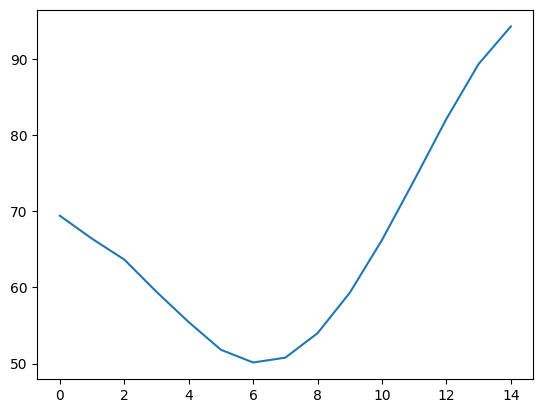

In [30]:
%matplotlib inline
plt.plot(ls)

# Re-train the model

In [31]:
lr = 0.001

prune_rnn, ls = train(
    model=prune_rnn,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=1000,
    gradient_ascent=False
)

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 715.37it/s]


# Plot predictions using the pruned model!

100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.39it/s]


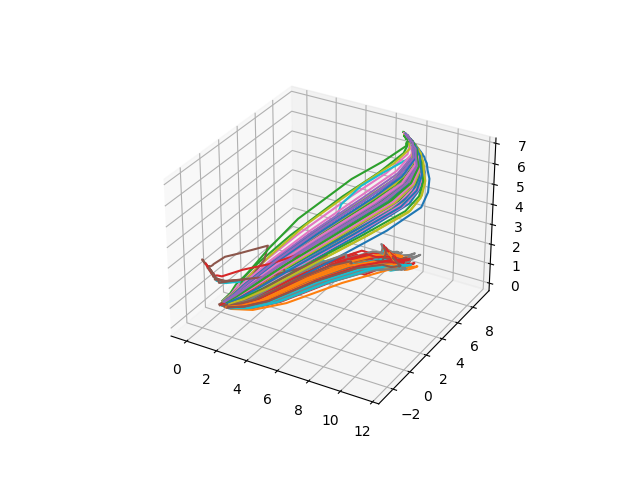

In [32]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
plot_preds(prune_rnn, inputs)

# We get our left-right back (albeit not perfectly) but you can see that the pruning remains!!

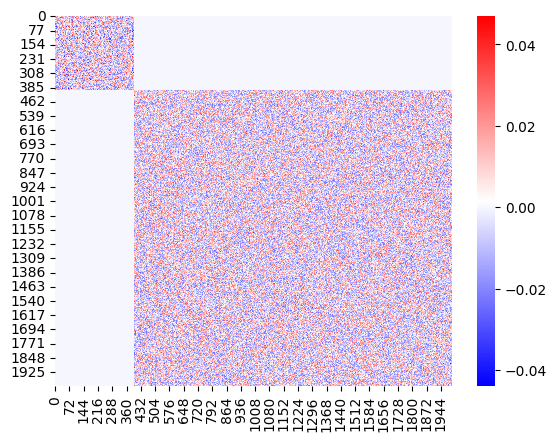

In [33]:
%matplotlib inline
sns.heatmap(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()